In [7]:
!pip install transformers
!pip install nltk
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import nltk
nltk.download('cmudict')
from nltk.corpus import cmudict

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package cmudict to /home/adithya/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


**Loading Speech signal**

In [9]:
file_path="dataset/LJSpeech-1.1/wavs/LJ001-0001.wav"
waveform,sample_rate=torchaudio.load(file_path)

**Loading the pretrained model and processor**

In [10]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
phoneme_dict = cmudict.dict()
def get_phonemes(word):
    word = word.lower()
    return phoneme_dict.get(word, ["UNKNOWN"])

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/843 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Audio preprocessing (Conversion to mono and Resampling to 16kHz)**

In [11]:
waveform = torch.mean(waveform,dim=0,keepdim=True)
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

**Converting the waveform into model input format and obtaining model predictions**

In [14]:
waveform_np = waveform.squeeze().numpy()
processed_audio = processor(waveform_np, return_tensors="pt", sampling_rate=16000)
input_values = processed_audio.input_values
with torch.no_grad():
    predictions = model(input_values)

**Converting predictions into phonemes and printing the recognised phonemes**

In [15]:
predicted_ids = torch.argmax(predictions.logits, dim=-1)
phoneme_list = processor.batch_decode(predicted_ids)
transcription = phoneme_list[0]
phoneme_output = [get_phonemes(word) for word in transcription.split()]
print("Recognized Text:", transcription)
print("Phonemes:", phoneme_output)

Recognized Text: PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION
Phonemes: [[['P', 'R', 'IH1', 'N', 'T', 'IH0', 'NG'], ['P', 'R', 'IH1', 'N', 'IH0', 'NG']], [['IH0', 'N'], ['IH1', 'N']], [['DH', 'AH0'], ['DH', 'AH1'], ['DH', 'IY0']], [['OW1', 'N', 'L', 'IY0']], [['S', 'EH1', 'N', 'S']], [['W', 'IH1', 'DH'], ['W', 'IH1', 'TH'], ['W', 'IH0', 'TH'], ['W', 'IH0', 'DH']], [['W', 'IH1', 'CH'], ['HH', 'W', 'IH1', 'CH']], [['W', 'IY1']], [['AA1', 'R'], ['ER0']], [['AE1', 'T']], [['P', 'R', 'EH1', 'Z', 'AH0', 'N', 'T'], ['P', 'R', 'IY0', 'Z', 'EH1', 'N', 'T'], ['P', 'ER0', 'Z', 'EH1', 'N', 'T']], [['K', 'AH0', 'N', 'S', 'ER1', 'N', 'D']], [['D', 'IH1', 'F', 'ER0', 'Z']], [['F', 'R', 'AH1', 'M'], ['F', 'ER0', 'M']], [['M', 'OW1', 'S', 'T'], ['M', 'OW1', 'S']], [['IH1', 'F'], ['IH0', 'F']], [['N', 'AA1', 'T']], [['F', 'R', 'AH1', 'M'], ['F', 'ER0', 'M']], [['AO1', 'L']], [['DH', 'AH0'], ['DH', 'A

**Extracting a phoneme segment based on time**

In [16]:
start_time = 1.0
end_time = 1.5
start_sample = int(start_time * 16000)
end_sample = int(end_time * 16000)
phoneme_segment = waveform[:, start_sample:end_sample]

**Alignment with recognised phoneme**

In [17]:
total_samples = waveform.size(1)
segment_duration = end_sample - start_sample
segment_ratio = start_sample / total_samples
num_words = len(transcription.split())
word_index = int(segment_ratio * num_words)
aligned_word = transcription.split()[word_index] if num_words > 0 else ''
aligned_phoneme = get_phonemes(aligned_word)

**Visualisation of waveform of extracted phoneme**

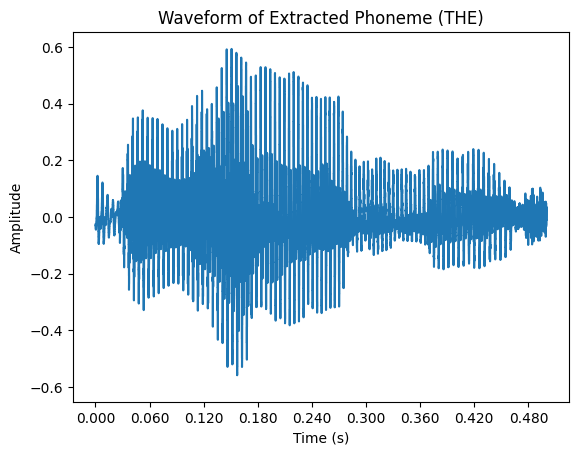

Aligned Word: THE
Phonemes for 'THE': [['DH', 'AH0'], ['DH', 'AH1'], ['DH', 'IY0']]


In [18]:
phoneme_array=phoneme_segment.numpy()
samples=phoneme_array.flatten()
librosa.display.waveshow(samples, sr=16000)
plt.title(f"Waveform of Extracted Phoneme ({aligned_word})")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()
print(f"Aligned Word: {aligned_word}")
print(f"Phonemes for '{aligned_word}': {aligned_phoneme}")